# Compare Urban and Rural Pizza price comparison by Web Scraping Little Caesars Prices

### Import Libraries

In [245]:
from selenium import webdriver
import json
import re
from lxml import html
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
from tqdm import tqdm
from selenium.webdriver.common.keys import Keys  
from selenium.webdriver.chrome.options import Options 
from collections import defaultdict 
from numpy import mean
import numpy as np

headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}

## Import the necessary data

### Lets import the Rural-Urban Continuum Codes file that classifies the county into 1 of 9 categories of metropolitan or not categories:

## Metropolitan Counties	

### Code	Description

    1 = Counties in metro areas of 1 million population or more

    2 = Counties in metro areas of 250,000 to 1 million population

    3 = Counties in metro areas of fewer than 250,000 population


## Nonmetropolitan Counties	

### Code	Description

    4 = Urban population of 20,000 or more, adjacent to a metro area

    5 = Urban population of 20,000 or more, not adjacent to a metro area

    6 = Urban population of 2,500 to 19,999, adjacent to a metro area

    7 = Urban population of 2,500 to 19,999, not adjacent to a metro area

    8 = Completely rural or less than 2,500 urban population, adjacent to a metro area

    9 = Completely rural or less than 2,500 urban population, not adjacent to a metro area

## Data Description
### Column	Description
    FIPS            State-County FIPS Code
    State           State abbreviation
    County_Name     County name
    Population_2010 Total population 2010 (From 2010 Census of Population Summary File 1)
    RUCC_2013       Rural-urban Continuum Codes, 2013
    Description     Description of code

In [32]:
rural_class_df = pd.read_excel('/Users/abhil/Projects/Pizza_Web_Scraping/ruralurbancodes2013.xls')

In [33]:
rural_class_df.head()

,FIPS,State,County_Name,Population_2010,RUCC_2013,Description
0,1001,AL,Autauga County,54571,2.0,"Metro - Counties in metro areas of 250,000 to ..."
1,1003,AL,Baldwin County,182265,3.0,Metro - Counties in metro areas of fewer than ...
2,1005,AL,Barbour County,27457,6.0,"Nonmetro - Urban population of 2,500 to 19,999..."
3,1007,AL,Bibb County,22915,1.0,Metro - Counties in metro areas of 1 million p...
4,1009,AL,Blount County,57322,1.0,Metro - Counties in metro areas of 1 million p...


In [364]:
rural_class_df[rural_class_df['State'] == 'CA']['County_Name'].nunique()

58

In [84]:
rural_class_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3234 entries, 0 to 3233
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   FIPS             3234 non-null   int64  
 1   State            3234 non-null   object 
 2   County_Name      3234 non-null   object 
 3   Population_2010  3234 non-null   int64  
 4   RUCC_2013        3232 non-null   float64
 5   Description      3234 non-null   object 
 6   county_class     3234 non-null   object 
dtypes: float64(1), int64(2), object(4)
memory usage: 177.0+ KB


In [37]:
rural_class_df['county_class'] = rural_class_df['Description'].apply(lambda x: x.split('-')[0])

In [66]:
zip_codes_df = pd.read_csv('/Users/abhil/Projects/Pizza_Web_Scraping/niccolley-us-zipcode-to-county-state/data/zip_county_fips_2018_03.csv')

In [67]:
zip_codes_df.head()

,zip,stcountyfp,city,state,countyname,classfp
0,36091,1001,Verbena,AL,Autauga County,H1
1,36758,1001,Plantersville,AL,Autauga County,H1
2,36006,1001,Billingsley,AL,Autauga County,H1
3,36067,1001,Prattville,AL,Autauga County,H1
4,36701,1001,Selma,AL,Autauga County,H1


In [90]:
zip_codes_df['RUCC'] = zip_codes_df['stcountyfp'].apply(lambda x: int(rural_class_df[rural_class_df['FIPS'] == int(x)]['RUCC_2013'].reset_index(drop = True)[0]))

In [110]:
zip_codes_df.head(10)

,zip,stcountyfp,city,state,countyname,classfp,RUCC,storeids
0,36091,1001,Verbena,AL,Autauga County,H1,2,[]
1,36758,1001,Plantersville,AL,Autauga County,H1,2,[]
2,36006,1001,Billingsley,AL,Autauga County,H1,2,[]
3,36067,1001,Prattville,AL,Autauga County,H1,2,[]
4,36701,1001,Selma,AL,Autauga County,H1,2,[]
5,36003,1001,Autaugaville,AL,Autauga County,H1,2,[]
6,36008,1001,Booth,AL,Autauga County,H1,2,[]
7,36068,1001,Prattville,AL,Autauga County,H1,2,[]
8,36022,1001,Deatsville,AL,Autauga County,H1,2,[]
9,36703,1001,Selma,AL,Autauga County,H1,2,[]


In [104]:
chrome_options = Options()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--window-size=1920,1080')

In [137]:
cali_zip_codes_df = zip_codes_df[zip_codes_df['state'] == 'CA'].reset_index(drop = True)

In [365]:
cali_zip_codes_df.head()

,zip,stcountyfp,city,state,countyname,classfp,RUCC,storeids,cheese_price,feast_price,bread_price,pepperoni_price,supreme_price
0,94501,6001,Alameda,CA,Alameda County,H1,1,"[14680003, 14680004, 14680002, 14680001, 14880...",6.46,12.26,4.78,6.46,12.39
1,94560,6001,Newark,CA,Alameda County,H1,1,"[34980001, 11470001, 11470003, 80045041, 80045...",5.86,12.46,4.93,5.99,12.13
2,94577,6001,San leandro,CA,Alameda County,H1,1,"[14880011, 14680001, 80045040, 80045042, 14680...",6.39,12.49,4.88,6.46,12.42
3,94578,6001,San leandro,CA,Alameda County,H1,1,"[80045040, 80045042, 14880011, 14680001, 80045...",6.39,12.59,4.90,6.53,12.46
4,94550,6001,Livermore,CA,Alameda County,H1,1,"[13480001, 19420001, 32470001, 31890001]",6.99,13.24,5.62,6.99,12.99


In [144]:
tq = tqdm(zip(cali_zip_codes_df.index, cali_zip_codes_df['zip']), desc = 'Processing', leave = True, disable = False)
cali_zip_codes_df['storeids'] = [[] for val in cali_zip_codes_df.index]
for i, zip_val in tq:
    driver = webdriver.Chrome(chrome_options = chrome_options, executable_path=r'/Users/abhil/Downloads/chromedriver')
    custom_url = 'https://api.cloud.littlecaesars.com/bff/api/stores?zip=' + str(zip_val)
    driver.get(custom_url)
    soup = BeautifulSoup(driver.page_source,'html.parser')
    driver.quit()
    
    text = soup.get_text()
    text = json.loads(text)
    
    cali_zip_codes_df.loc[i, 'storeids'].extend([elem['storeId'] for elem in text['stores']])
    

Processing: 0it [00:00, ?it/s]<ipython-input-144-8da960dcd9e1>:4: DeprecationWarning: use options instead of chrome_options
  driver = webdriver.Chrome(chrome_options = chrome_options, executable_path=r'/Users/abhil/Downloads/chromedriver')
Processing: 2645it [1:33:22,  2.12s/it]


In [145]:
cali_zip_codes_df.head()

,zip,stcountyfp,city,state,countyname,classfp,RUCC,storeids
0,94501,6001,Alameda,CA,Alameda County,H1,1,"[14680003, 14680004, 14680002, 14680001, 14880..."
1,94560,6001,Newark,CA,Alameda County,H1,1,"[34980001, 11470001, 11470003, 80045041, 80045..."
2,94577,6001,San leandro,CA,Alameda County,H1,1,"[14880011, 14680001, 80045040, 80045042, 14680..."
3,94578,6001,San leandro,CA,Alameda County,H1,1,"[80045040, 80045042, 14880011, 14680001, 80045..."
4,94550,6001,Livermore,CA,Alameda County,H1,1,"[13480001, 19420001, 32470001, 31890001]"


In [8]:
store_id_dict = defaultdict(lambda :None)

In [167]:
cali_zip_codes_df.head()

,zip,stcountyfp,city,state,countyname,classfp,RUCC,storeids,cheese_price,feast_price,bread_price
0,94501,6001,Alameda,CA,Alameda County,H1,1,"[14680003, 14680004, 14680002, 14680001, 14880...",6.99,13.99,5
1,94560,6001,Newark,CA,Alameda County,H1,1,"[34980001, 11470001, 11470003, 80045041, 80045...",5,12,4.5
2,94577,6001,San leandro,CA,Alameda County,H1,1,"[14880011, 14680001, 80045040, 80045042, 14680...",6.99,12.99,5
3,94578,6001,San leandro,CA,Alameda County,H1,1,"[80045040, 80045042, 14880011, 14680001, 80045...",6.99,12,4.5
4,94550,6001,Livermore,CA,Alameda County,H1,1,"[13480001, 19420001, 32470001, 31890001]",,,


In [226]:
cali_zip_codes_df = cali_zip_codes_df[cali_zip_codes_df['storeids'].str.len() > 0].reset_index(drop = True)

In [176]:
all_store_ids = []
for storeid in cali_zip_codes_df['storeids']:
    all_store_ids.extend(storeid)

In [179]:
len(all_store_ids)

22564

In [181]:
all_store_ids = set(all_store_ids)

In [305]:
store_id_dict = defaultdict(lambda :None)

In [306]:
for store_id in all_store_ids:
    driver = webdriver.Chrome(chrome_options = chrome_options, executable_path=r'/Users/abhil/Downloads/chromedriver')
    new_url = 'https://api.cloud.littlecaesars.com/bff/api/stores/'+ str(store_id) + '/menu'
    driver.get(new_url)
    soup = BeautifulSoup(driver.page_source,'html.parser')
    driver.quit()

    text = soup.get_text()
    text = json.loads(text)
    for elem in text['menuItems']:
        if elem['itemName'] == 'Classic Cheese':
            cheese_price = elem['price']
        if elem['itemName'] == '5 Meat Feast™':
            feast_price = elem['price']
        if elem['itemName'] == 'Italian Cheese Bread':
            bread_price = elem['price']
        if elem['itemName'] == 'Classic Pepperoni':
            classic_pep = elem['price']
        if elem['itemName'] == 'Ultimate Supreme':
            ulti_supreme = elem['price']
        
    store_id_dict[store_id] = [cheese_price, feast_price, bread_price, classic_pep, ulti_supreme]
    

<ipython-input-306-da76dc3738be>:2: DeprecationWarning:

use options instead of chrome_options



In [307]:
tq = tqdm(zip(cali_zip_codes_df.index, cali_zip_codes_df['storeids']), desc = 'Processing', leave = True, disable = False)
cali_zip_codes_df['cheese_price'] = [np.NaN for val in cali_zip_codes_df.index]
cali_zip_codes_df['feast_price'] = [np.NaN for val in cali_zip_codes_df.index]
cali_zip_codes_df['bread_price'] = [np.NaN for val in cali_zip_codes_df.index]
cali_zip_codes_df['pepperoni_price'] = [np.NaN for val in cali_zip_codes_df.index]
cali_zip_codes_df['supreme_price'] = [np.NaN for val in cali_zip_codes_df.index]
for i, store_nums in tq:
    cheese_prices = []
    feast_prices = []
    bread_prices = []
    classic_pep = []
    ulti_supreme = []
    for store_num in store_nums:
        cheese_prices.append(store_id_dict[store_num][0])
        feast_prices.append(store_id_dict[store_num][1])
        bread_prices.append(store_id_dict[store_num][2])
        classic_pep.append(store_id_dict[store_num][3])
        ulti_supreme.append(store_id_dict[store_num][4])
        
    cali_zip_codes_df.loc[i, 'cheese_price'] = round(mean(list(filter(lambda a: a !=0, cheese_prices))), 2)
    cali_zip_codes_df.loc[i, 'feast_price'] = round(mean(list(filter(lambda a: a !=0, feast_prices))), 2)
    cali_zip_codes_df.loc[i, 'bread_price'] = round(mean(list(filter(lambda a: a !=0, bread_prices))), 2)
    cali_zip_codes_df.loc[i, 'pepperoni_price'] = round(mean(list(filter(lambda a: a !=0, classic_pep))), 2)
    cali_zip_codes_df.loc[i, 'supreme_price'] = round(mean(list(filter(lambda a: a !=0, ulti_supreme))), 2)


Processing: 0it [00:00, ?it/s]
Processing: 63it [00:00, 622.15it/s]/usr/local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars


Processing: 149it [00:00, 676.71it/s]
Processing: 237it [00:00, 725.72it/s]
Processing: 327it [00:00, 768.84it/s]
Processing: 412it [00:00, 790.17it/s]
Processing: 499it [00:00, 811.14it/s]
Processing: 585it [00:00, 824.44it/s]
Processing: 674it [00:00, 842.88it/s]
Processing: 758it [00:00, 841.83it/s]
Processing: 847it [00:01, 853.87it/s]
Processing: 935it [00:01, 857.63it/s]
Processing: 1021it [00:01, 855.37it/s]
Processing: 1107it [00:01, 855.79it/s]
Processing: 1194it [00:01, 859.56it/s]
Processing: 1280it [00:01, 829.61it/s]
Processing: 1364it [00:01, 831.24it/s]
Processing: 1452it [00:01, 843.97it/s]
Processing: 1539it [00:01, 851.30it/s]
Processing: 1625it [00:01, 850.20it/s]


In [309]:
agg_df = cali_zip_codes_df[['RUCC', 'cheese_price','feast_price', 'bread_price', 'pepperoni_price', 'supreme_price']].groupby(['RUCC']).mean()

In [310]:
agg_df = agg_df.reset_index(drop = False)

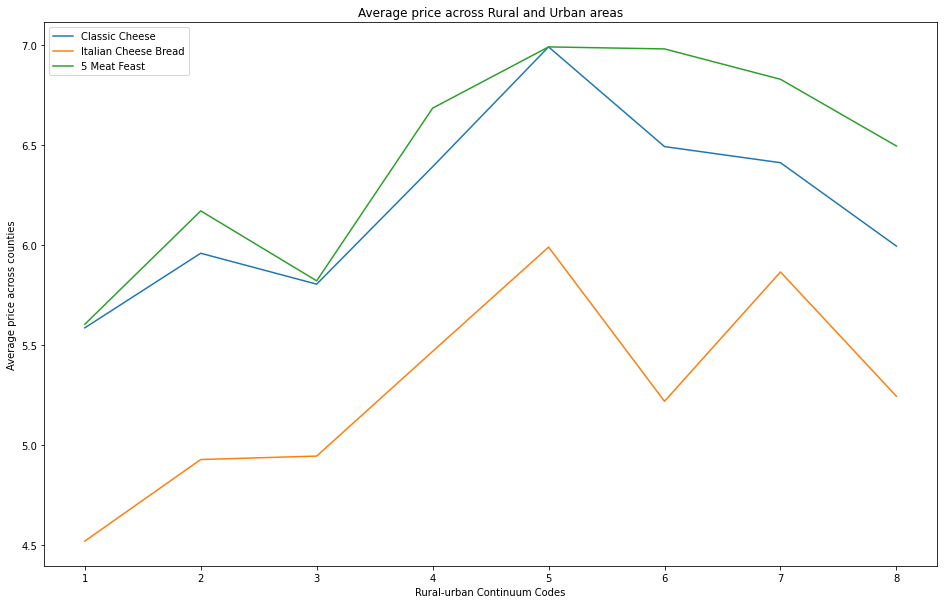

In [326]:
import matplotlib.pyplot as plt
plt.figure(figsize= (16,10))
plt.plot(agg_df['RUCC'], agg_df['cheese_price'], label = 'Classic Cheese')
#plt.plot(agg_df['RUCC'], agg_df['feast_price'], label = 'feast')
plt.plot(agg_df['RUCC'], agg_df['bread_price'], label = 'Italian Cheese Bread')
plt.plot(agg_df['RUCC'], agg_df['pepperoni_price'], label = '5 Meat Feast')
#plt.plot(agg_df['RUCC'], agg_df['supreme_price'], label = 'bread')
plt.xlabel('Rural-urban Continuum Codes')
plt.ylabel('Average price across counties')
plt.title('Average price across Rural and Urban areas')
plt.legend(loc="upper left")

plt.show()

In [362]:
cali_zip_codes_df.to_csv('california_metro_pizza_prices.csv')

In [319]:
group_df = cali_zip_codes_df[['RUCC', 'cheese_price','feast_price', 'bread_price', 'pepperoni_price', 'supreme_price']].groupby(['RUCC']).mean().reset_index(drop = False)

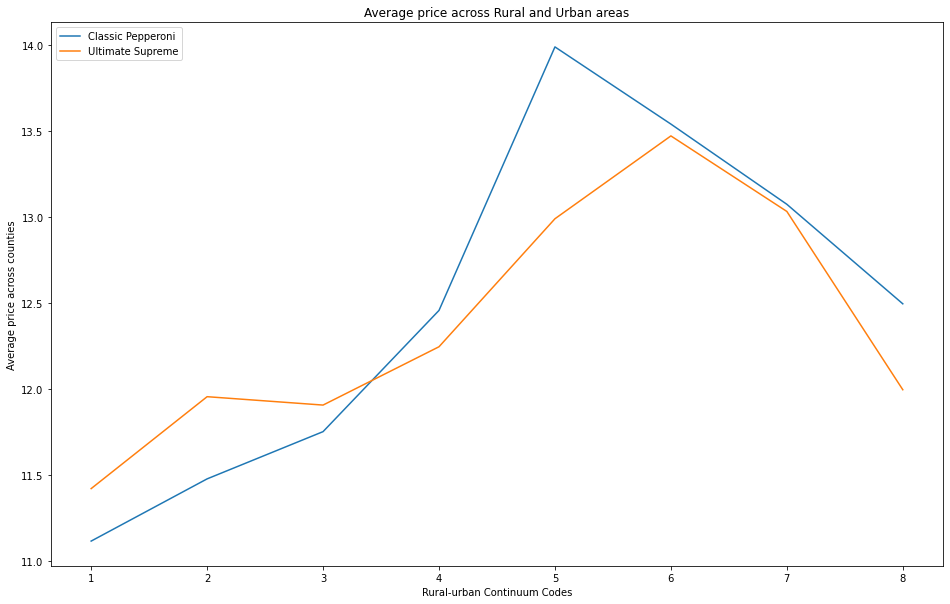

In [327]:
plt.figure(figsize= (16,10))
#plt.plot(agg_df['RUCC'], agg_df['cheese_price'], label = 'cheese')
plt.plot(agg_df['RUCC'], agg_df['feast_price'], label = 'Classic Pepperoni')
#plt.plot(agg_df['RUCC'], agg_df['bread_price'], label = 'bread')
#plt.plot(agg_df['RUCC'], agg_df['pepperoni_price'], label = 'feast')
plt.plot(agg_df['RUCC'], agg_df['supreme_price'], label = 'Ultimate Supreme')
plt.xlabel('Rural-urban Continuum Codes')
plt.ylabel('Average price across counties')
plt.title('Average price across Rural and Urban areas')
plt.legend(loc="upper left")

plt.show()

In [341]:
mean_df = group_df.round(2).set_index('RUCC').T

In [347]:
mean_df.append(mean_df.sum(numeric_only=True), ignore_index=True)


RUCC,1,2,3,4,5,6,7,8,Diff_1_and_5
0,5.59,5.96,5.80,6.39,6.99,6.49,6.41,6.00,-1.40
1,11.11,11.48,11.75,12.46,13.99,13.54,13.07,12.50,-2.88
2,4.52,4.93,4.95,5.47,5.99,5.22,5.87,5.24,-1.47
3,5.60,6.17,5.82,6.68,6.99,6.98,6.83,6.50,-1.39
4,11.42,11.95,11.91,12.25,12.99,13.47,13.03,12.00,-1.57
5,38.24,40.49,40.23,43.25,46.95,45.70,45.21,42.24,-8.71


In [342]:
mean_df

RUCC,1,2,3,4,5,6,7,8
cheese_price,5.59,5.96,5.80,6.39,6.99,6.49,6.41,6.00
feast_price,11.11,11.48,11.75,12.46,13.99,13.54,13.07,12.50
bread_price,4.52,4.93,4.95,5.47,5.99,5.22,5.87,5.24
pepperoni_price,5.60,6.17,5.82,6.68,6.99,6.98,6.83,6.50
supreme_price,11.42,11.95,11.91,12.25,12.99,13.47,13.03,12.00


In [343]:
mean_df['Diff_1_and_5'] = mean_df[1] - mean_df[5]

In [345]:
mean_df['Diff_1_and_5'].sum()

-8.710000000000003

In [346]:
mean_df

RUCC,1,2,3,4,5,6,7,8,Diff_1_and_5
cheese_price,5.59,5.96,5.80,6.39,6.99,6.49,6.41,6.00,-1.40
feast_price,11.11,11.48,11.75,12.46,13.99,13.54,13.07,12.50,-2.88
bread_price,4.52,4.93,4.95,5.47,5.99,5.22,5.87,5.24,-1.47
pepperoni_price,5.60,6.17,5.82,6.68,6.99,6.98,6.83,6.50,-1.39
supreme_price,11.42,11.95,11.91,12.25,12.99,13.47,13.03,12.00,-1.57


In [357]:
group_df.round(2)

,RUCC,cheese_price,feast_price,bread_price,pepperoni_price,supreme_price
0,1,5.59,11.11,4.52,5.60,11.42
1,2,5.96,11.48,4.93,6.17,11.95
2,3,5.80,11.75,4.95,5.82,11.91
3,4,6.39,12.46,5.47,6.68,12.25
4,5,6.99,13.99,5.99,6.99,12.99
5,6,6.49,13.54,5.22,6.98,13.47
6,7,6.41,13.07,5.87,6.83,13.03
7,8,6.00,12.50,5.24,6.50,12.00


In [359]:
mean_df['metro'] = round((mean_df[1] + mean_df[2] + mean_df[3])/3, 2)
mean_df['non_metro'] = round((mean_df[4] + mean_df[5] + mean_df[6] + mean_df[7] + mean_df[8])/5, 2)

In [360]:
mean_df

RUCC,1,2,3,4,5,6,7,8,Diff_1_and_5,metro,non_metro
cheese_price,5.59,5.96,5.80,6.39,6.99,6.49,6.41,6.00,-1.40,5.78,6.46
feast_price,11.11,11.48,11.75,12.46,13.99,13.54,13.07,12.50,-2.88,11.45,13.11
bread_price,4.52,4.93,4.95,5.47,5.99,5.22,5.87,5.24,-1.47,4.80,5.56
pepperoni_price,5.60,6.17,5.82,6.68,6.99,6.98,6.83,6.50,-1.39,5.86,6.80
supreme_price,11.42,11.95,11.91,12.25,12.99,13.47,13.03,12.00,-1.57,11.76,12.75


In [361]:
mean_df.T

,cheese_price,feast_price,bread_price,pepperoni_price,supreme_price
RUCC,,,,,
1,5.59,11.11,4.52,5.60,11.42
2,5.96,11.48,4.93,6.17,11.95
3,5.80,11.75,4.95,5.82,11.91
4,6.39,12.46,5.47,6.68,12.25
5,6.99,13.99,5.99,6.99,12.99
6,6.49,13.54,5.22,6.98,13.47
7,6.41,13.07,5.87,6.83,13.03
8,6.00,12.50,5.24,6.50,12.00
Diff_1_and_5,-1.40,-2.88,-1.47,-1.39,-1.57
